In [1]:
import xarray as xr
import numpy as np
from functools import reduce
import matplotlib.pyplot as plt
from scipy import ndimage
import sys
sys.path.insert(0, '/Users/acheung/TC_RI_P1/scripts/Useful Functions/')
from cylindrical_conversion import circle
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from distance import pointdist_calc,get_angle
import pandas as pd
from cylindrical_conversion import interp_to_equal_grid,circle,x_y_grid_to_cylindrical
from scipy.interpolate import RegularGridInterpolator
from scipy import stats


In [2]:
# Settings
height = 2
polar_boolean = True
swath_boolean = True

In [3]:
if swath_boolean == True:
    nc_file_paths = ['/Users/acheung/data/TC_RADAR/swath/tc_radar_v3k_1997_2019_xy_rel_swath_ships.nc?download=1',
                     '/Users/acheung/data/TC_RADAR/swath/tc_radar_v3k_2020_2022_xy_rel_swath_ships.nc?download=1']   
else:
    nc_file_paths = ['/Users/acheung/data/TC_RADAR/merged/tc_radar_v3k_1997_2019_xy_rel_merge_ships.nc?download=1',
                 '/Users/acheung/data/TC_RADAR/merged/tc_radar_v3k_2020_2022_xy_rel_merge_ships.nc?download=1']


tc_radar_data_pre = xr.open_mfdataset(nc_file_paths,combine='nested',concat_dim='num_cases')
tc_radar_data_pre['num_cases'] = range(0,len(tc_radar_data_pre['num_cases']))

# Set initial conditions and filtering
far_from_land_cases =tc_radar_data_pre['dtl_ships'].sel(
    num_ships_times=0).load().where(
    tc_radar_data_pre['dtl_ships'].sel(num_ships_times=0).load() >=50).dropna('num_cases')['num_cases']

stype_cases = tc_radar_data_pre['stype_ships'].sel(num_ships_times=0).load().where((
    tc_radar_data_pre['stype_ships'].sel(num_ships_times=0).load()== 1) | (
    tc_radar_data_pre['stype_ships'].sel(num_ships_times=0).load()== 2)).dropna('num_cases')['num_cases']

tilt_mag = tc_radar_data_pre.sel(level=[5,5.5,6,6.5])['tc_tilt_magnitude'].max(
    dim='level').dropna(dim='num_cases')

selected_tilt_level_inds = tc_radar_data_pre.sel(num_cases=tilt_mag['num_cases'],
                      level=[5,5.5,6,6.5])['tc_tilt_magnitude'].argmax(dim='level',keep_attrs=True)

tilt_angs = tc_radar_data_pre.sel(num_cases=tilt_mag['num_cases'],
                      level=[5,5.5,6,6.5])['tc_tilt_direction']*(180/np.pi)

list_of_lists = [stype_cases.values,far_from_land_cases.values,tilt_mag['num_cases'].values]
# list_of_lists = [far_from_land_cases.values,tilt_mag['num_cases'].values]

result = list(reduce(lambda a, b: set(a) & set(b), list_of_lists))

filtered_tc_radar = tc_radar_data_pre.sel(num_cases=result)

data_selection = 'recentered_wind_speed'

if data_selection == 'recentered_reflectivity':
    corrected_data = xr.open_dataset('/Users/acheung/data/TC_RADAR/merged/tc_radar_v3k_corrected_ref.nc?download=1')
    corrected_data = corrected_data.assign(num_cases=corrected_data["num_cases"])
    filtered_data = corrected_data['recentered_corrected_reflectivity'].sel(num_cases=result,level=2)
else:
    filtered_data = filtered_tc_radar.sel(level=2)[data_selection]

rotated_images = [] # Rotated images in physical space
cylindrical_tc_radar_data_normalized_list = [] # Rotate Images in normalized polar RMW space
mlc_list = [] # This is to get all MLC lat/lons. This is needed because height varies based on max tilt mag.

# Rotate Images and create cylindrical plots
for rot_i in filtered_data['num_cases']:
# for rot_i in [239]:

    print(int(rot_i))
    rotate_setting = 'Tilt-Direction'
    if rotate_setting == 'Tilt-Direction':
        angle_rotate = float(tilt_angs.sel(num_cases=int(rot_i)).isel(
                                    level=int(selected_tilt_level_inds.sel(num_cases=int(rot_i)))))
    elif rotate_setting == 'Shear-Direction':
        angle_rotate = 90 - float(filtered_tc_radar['shtd_ships'].sel(num_cases=int(rot_i),num_ships_times=0))
    img_rotate = ndimage.rotate(filtered_data.sel(num_cases=int(rot_i)),angle_rotate,
                                reshape=False,order=0,mode='constant',cval=np.nan)
    rotated_images.append(img_rotate)
    
    mlc_lon = float(filtered_tc_radar['tc_center_longitudes'].sel(num_cases=int(rot_i),level=[5,5.5,6,6.5]).isel(level=int(selected_tilt_level_inds.sel(num_cases=int(rot_i)))))
    mlc_lat = float(filtered_tc_radar['tc_center_latitudes'].sel(num_cases=int(rot_i),level=[5,5.5,6,6.5]).isel(level=int(selected_tilt_level_inds.sel(num_cases=int(rot_i)))))
    # Find MLC relative to 2-km center
    two_km_lon = filtered_tc_radar['tc_center_longitudes'].sel(num_cases=int(rot_i),level=2)
    two_km_lat = filtered_tc_radar['tc_center_latitudes'].sel(num_cases=int(rot_i),level=2)
    
    dist_to_mid_center = pointdist_calc(mlc_lat,mlc_lon,two_km_lat,two_km_lon)

    # This is NOT a perfect estimate of the angle, given the Earth's curvature

    angle_to_mlc = get_angle(two_km_lon,two_km_lat,mlc_lon,mlc_lat) # degrees from math angle zero, or east
   
    # Find location of MLC on tilt-relative grid

    mlc_rotated_angle = angle_to_mlc - angle_rotate

    mlc_x = dist_to_mid_center * np.cos(mlc_rotated_angle*(np.pi/180))
    mlc_y = dist_to_mid_center * np.sin(mlc_rotated_angle*(np.pi/180))
    
    mlc_list.append([int(rot_i),float(two_km_lat),float(two_km_lon),mlc_lat,mlc_lon,float(mlc_x),float(mlc_y),angle_rotate])
    
    # Create RMW normalized data cylindrical data
    desired_normalized_rad_arr = np.arange(0,6.01,0.01)
    cylindrical_normalized_list = []
    if polar_boolean == True:
        cylindrical_tc_radar_data, THETA, rad_arr = x_y_grid_to_cylindrical(
            center_inds=[0,0],radius_min=0,radius_max=200,radius_interval=1, NOP=1000,
            x_grid=filtered_data['x_dist'],y_grid=filtered_data['y_dist'],
            data=img_rotate)

        # Interpolate data to normalized RMW spacings
        rmw_now = float(filtered_tc_radar['tc_rmw'].sel(num_cases=int(rot_i),level=2))
        normalized_rad_arr = rad_arr/rmw_now

        polar_tc_radar_interp = RegularGridInterpolator((normalized_rad_arr,THETA),
                                                        cylindrical_tc_radar_data,bounds_error=False)

        theta_mesh,desired_rad_mesh = np.meshgrid(THETA,desired_normalized_rad_arr)
        polar_rad_norm_data = polar_tc_radar_interp((desired_rad_mesh,THETA))            

        cylindrical_tc_radar_data_normalized_list.append(polar_rad_norm_data)
        
mlc_pd = pd.DataFrame(mlc_list,columns=['num_cases','2-km Lat','2-km Lon','MLC Lat','MLC Lon','MLC X (rotated)',
                          'MLC Y (rotated)','Tilt Angle'])
mlc_pd.index = mlc_pd['num_cases']


0
1
2
3
4
5
6
7
8
9
10
12
13
14
16
17
18
19
20
21
22
23
24
25
26
27
28
29
31
32
33
34
35
36
37
38
39
40
41
43
44
45
46
47
48
49
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
70
72
73
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
99
100
101
102
103
104
105
106
107
109
110
111
114
115
117
118
119
120
121
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
153
154
155
156
157
167
168
169
170
171
172
173
174
175
179
180
181
182
183
184
185
186
187
188
189
190
191
198
199
200
201
202
203
204
205
206
207
208
209
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
246
247
248
249
251
252
253
254
255
256
257
258
259
260
261
262
266
267
268
269
270
271
272
273
274
275
276
277
278
279
280
281
282
283
284
285
286
287
288
289
290
291
292
293
294
295
296
302
305
306
308
309
310
311
312
313
314
315
316
317
318
319
320
321
322
323
324
325
327
328
3

In [4]:
filtered_tc_radar

<xarray.Dataset> Size: 186GB
Dimensions:                                          (num_cases: 887,
                                                      level: 37,
                                                      num_ships_times: 17,
                                                      lats: 200, lons: 200,
                                                      y_dist: 201, x_dist: 201)
Coordinates:
  * num_cases                                        (num_cases) int64 7kB 0 ...
  * level                                            (level) float32 148B 0.0...
  * num_ships_times                                  (num_ships_times) float32 68B ...
  * x_dist                                           (x_dist) float32 804B -2...
  * y_dist                                           (y_dist) float32 804B -2...
Dimensions without coordinates: lats, lons
Data variables: (12/89)
    original_longitudes                              (num_cases, lats, lons) float32 142MB dask.array<chunksize=(147, 50, 50), meta=np.ndarray>
    original_latitudes                               (num_cases, lats, lons) float32 142MB dask.array<chunksize=(147, 50, 50), meta=np.ndarray>
    recentered_longitudes                            (num_cases, y_dist, x_dist) float32 143MB dask.array<chunksize=(147, 51, 51), meta=np.ndarray>
    recentered_latitudes                             (num_cases, y_dist, x_dist) float32 143MB dask.array<chunksize=(147, 51, 51), meta=np.ndarray>
    total_recentered_longitudes                      (num_cases, y_dist, x_dist, level) float32 5GB dask.array<chunksize=(102, 34, 34, 6), meta=np.ndarray>
    total_recentered_latitudes                       (num_cases, y_dist, x_dist, level) float32 5GB dask.array<chunksize=(102, 34, 34, 6), meta=np.ndarray>
    ...                                               ...
    rhhi_ships                                       (num_cases, num_ships_times) float32 60kB dask.array<chunksize=(576, 17), meta=np.ndarray>
    dtl_ships                                        (num_cases, num_ships_times) float32 60kB dask.array<chunksize=(576, 17), meta=np.ndarray>
    mpi_ships                                        (num_cases, num_ships_times) float32 60kB dask.array<chunksize=(576, 17), meta=np.ndarray>
    sst_ships                                        (num_cases, num_ships_times) float32 60kB dask.array<chunksize=(576, 17), meta=np.ndarray>
    ohc_ships                                        (num_cases, num_ships_times) float32 60kB dask.array<chunksize=(576, 17), meta=np.ndarray>
    stype_ships                                      (num_cases, num_ships_times) float32 60kB dask.array<chunksize=(576, 17), meta=np.ndarray>
Attributes:
    description:  NOAA WP-3D tail Doppler radar data for select swath analyses

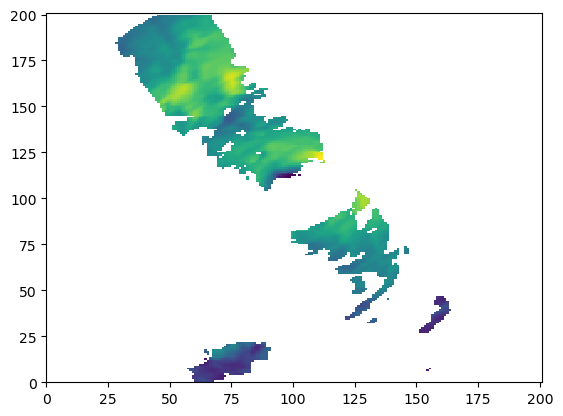

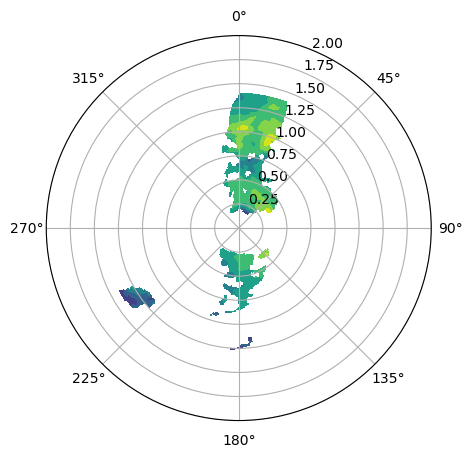

In [5]:
plt.pcolormesh(filtered_data.sel(num_cases=int(rot_i)))

fig = plt.figure(figsize=(20, 5)) 

gs = fig.add_gridspec(1,1)
ax = fig.add_subplot(gs[0, 0],adjustable='box', aspect=1,projection='polar')
ax.grid(True)
ax.set_theta_direction(-1)
ax.set_theta_zero_location('N')
ax.set_rlim(0,2)
ax.contourf(THETA,desired_normalized_rad_arr,polar_rad_norm_data)

In [6]:
# Create xarrays for image data

finalx,finaly = np.meshgrid(filtered_data.x_dist.data,filtered_data.y_dist.data)
rotated_images_xr = xr.DataArray(rotated_images,dims=["num_cases","x", "y"],coords=dict(
        x=(["x", "y"], finalx),
        y=(["x", "y"], finaly),
        num_cases=filtered_data['num_cases'].values))

theta_mesh,desired_rad_mesh = np.meshgrid(THETA,desired_normalized_rad_arr)

all_cylindrical_tc_radar_xr = xr.DataArray(cylindrical_tc_radar_data_normalized_list,
                                  dims=["num_cases","radius", "azimuth"],coords=dict(
        azimuth=(["radius", "azimuth"], theta_mesh),
        radius=(["radius", "azimuth"], desired_rad_mesh),
               num_cases=filtered_data['num_cases'].values))

In [7]:
strong_cases = filtered_tc_radar['vmax_ships'].sel(num_ships_times=0).where(
    filtered_tc_radar['vmax_ships'].sel(num_ships_times=0) > 65).dropna('num_cases')
weak_cases = filtered_tc_radar['vmax_ships'].sel(num_ships_times=0).where(
    filtered_tc_radar['vmax_ships'].sel(num_ships_times=0) <= 65).dropna('num_cases')

weak_info_xr = filtered_tc_radar.sel(num_cases=weak_cases['num_cases'].values)

weak_rotated = rotated_images_xr.sel(num_cases=weak_cases['num_cases'])

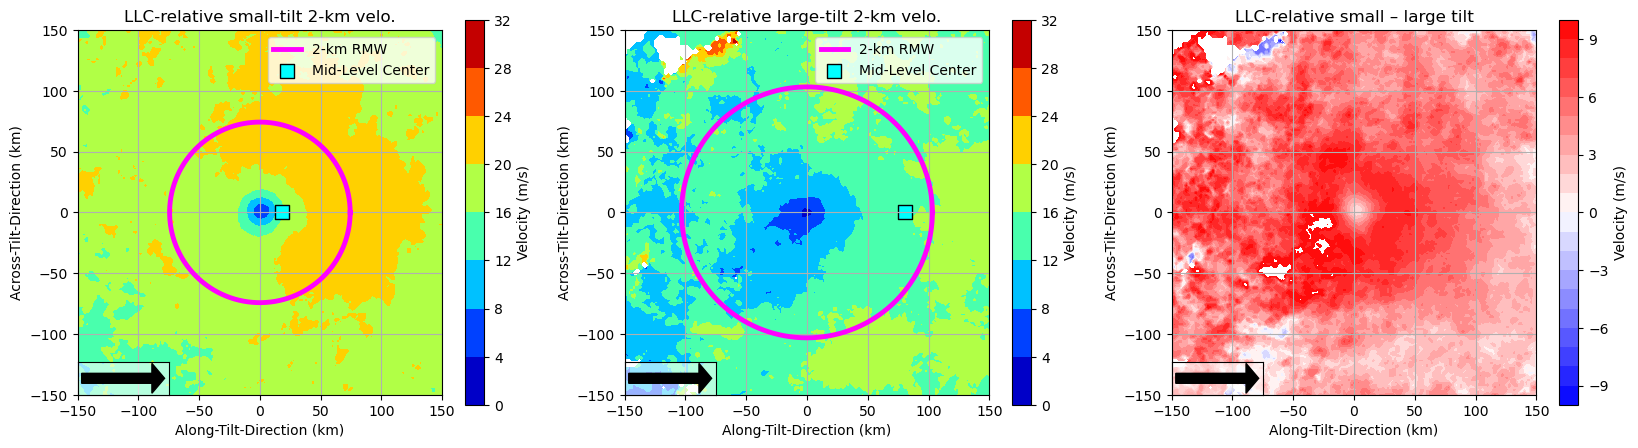

In [8]:
large_tilt_indices = tilt_mag.sel(num_cases=weak_info_xr['num_cases'].values
                                 ).where(tilt_mag.sel(num_cases=weak_info_xr['num_cases'].values) >= 40).dropna('num_cases')['num_cases']
small_tilt_indices = tilt_mag.sel(num_cases=weak_info_xr['num_cases'].values
                                 ).where(tilt_mag.sel(num_cases=weak_info_xr['num_cases'].values) < 40).dropna('num_cases')['num_cases']


mean_small_tilt_rmw = filtered_tc_radar['tc_rmw'].sel(num_cases=small_tilt_indices,level=2).mean()
mean_large_tilt_rmw = filtered_tc_radar['tc_rmw'].sel(num_cases=large_tilt_indices,level=2).mean()
X1,Y1,THETA1 = circle([0,0],float(mean_small_tilt_rmw.mean().values),1000)
X2,Y2,THETA2 = circle([0,0],float(mean_large_tilt_rmw.mean().values),1000)

# Find mean MLCs

small_tilt_mlc_x = mlc_pd['MLC X (rotated)'][small_tilt_indices].mean()
small_tilt_mlc_y = mlc_pd['MLC Y (rotated)'][small_tilt_indices].mean()
large_tilt_mlc_x = mlc_pd['MLC X (rotated)'][large_tilt_indices].mean()
large_tilt_mlc_y = mlc_pd['MLC Y (rotated)'][large_tilt_indices].mean()

fig = plt.figure(figsize=(20, 5)) 

gs = fig.add_gridspec(1,3)
ax = fig.add_subplot(gs[0, 0],adjustable='box', aspect=1)
ax2 = fig.add_subplot(gs[0, 1],adjustable='box', aspect=1)
ax3 = fig.add_subplot(gs[0, 2],adjustable='box', aspect=1)

if data_selection == 'recentered_reflectivity':
    p1 = ax.contourf(rotated_images_xr['x'],rotated_images_xr['y'],
                 rotated_images_xr.sel(num_cases=small_tilt_indices).mean('num_cases'),cmap='jet',
                 levels=np.arange(0,35.1,2.5))
    plt.colorbar(p1,label='Reflectivity (dBZ)')
    ax.set_title('LLC-relative small-tilt 2-km ref.')

else:
    p1 = ax.contourf(rotated_images_xr['x'],rotated_images_xr['y'],
                 rotated_images_xr.sel(num_cases=small_tilt_indices).mean('num_cases'),cmap='jet',
                     levels=np.arange(0,32.1,4))
    plt.colorbar(p1,label='Velocity (m/s)')
    ax.set_title('LLC-relative small-tilt 2-km velo.')


# Plotting
if data_selection == 'recentered_reflectivity':
    ax.contour(rotated_images_xr['x'],rotated_images_xr['y'],
                 rotated_images_xr.sel(num_cases=small_tilt_indices).mean('num_cases'),levels=[20])
# else:
#     ax.contour(rotated_images_xr['x'],rotated_images_xr['y'],
#                  rotated_images_xr.sel(num_cases=small_tilt_indices).mean('num_cases'))
ax.plot(X1,Y1,'magenta',lw=3.5,label = str(height)+'-km RMW')
ax.scatter(small_tilt_mlc_x,small_tilt_mlc_y,s=100,linewidths = 1,edgecolors = 'k',
               color='cyan',marker='s',label='Mid-Level Center')

ax.set_xlim(-150,150)
ax.set_ylim(-150,150)
ax.set_xlabel('Along-'+rotate_setting +' (km)')
ax.set_ylabel('Across-'+rotate_setting +' (km)')
ax.grid(True)
ax.legend()
axins = inset_axes(ax, width="25%", height="9%", loc=3, borderpad=0)
axins.tick_params(labelleft=False, labelbottom=False,left = False,bottom = False)
axins.patch.set_alpha(0.6)
# axins.set_title(rotate_setting, y=-1.21)
q = axins.arrow(0,0,0.05,0,color='black',head_length = 0.009)

if data_selection == 'recentered_reflectivity':
    p2 = ax2.contourf(rotated_images_xr['x'],rotated_images_xr['y'],
                 rotated_images_xr.sel(num_cases=large_tilt_indices).mean('num_cases'),cmap='jet',
                 levels=np.arange(0,35.1,2.5))
    plt.colorbar(p2,label='Reflectivity (dBZ)')
    ax2.set_title('LLC-relative large-tilt 2-km ref.')
else:
    p2 = ax2.contourf(rotated_images_xr['x'],rotated_images_xr['y'],
             rotated_images_xr.sel(num_cases=large_tilt_indices).mean('num_cases'),cmap='jet',
                     levels=np.arange(0,32.1,4))
    plt.colorbar(p2,label='Velocity (m/s)')
    ax2.set_title('LLC-relative large-tilt 2-km velo.')


# Plotting
if data_selection == 'recentered_reflectivity':
    ax2.contour(rotated_images_xr['x'],rotated_images_xr['y'],
                 rotated_images_xr.sel(num_cases=large_tilt_indices).mean('num_cases'),levels=[20])
# else:
#     ax2.contour(rotated_images_xr['x'],rotated_images_xr['y'],
#                  rotated_images_xr.sel(num_cases=large_tilt_indices).mean('num_cases'))
ax2.plot(X2,Y2,'magenta',lw=3.5,label = str(height)+'-km RMW')
ax2.scatter(large_tilt_mlc_x,large_tilt_mlc_y,s=100,linewidths = 1,edgecolors = 'k',
               color='cyan',marker='s',label='Mid-Level Center')
ax2.legend()
ax2.set_xlabel('Along-'+rotate_setting +' (km)')
ax2.set_ylabel('Across-'+rotate_setting +' (km)')
ax2.set_xlim(-150,150)
ax2.set_ylim(-150,150)
ax2.grid(True)
axins2 = inset_axes(ax2, width="25%", height="9%", loc=3, borderpad=0)
axins2.tick_params(labelleft=False, labelbottom=False,left = False,bottom = False)
axins2.patch.set_alpha(0.6)
# axins2.set_title(rotate_setting, y=-1.21)
q2 = axins2.arrow(0,0,0.05,0,color='black',head_length = 0.009)

# Plotting
if data_selection == 'recentered_reflectivity':
    p3 = ax3.contourf(rotated_images_xr['x'],rotated_images_xr['y'],
                 rotated_images_xr.sel(num_cases=small_tilt_indices).mean('num_cases')-
                 rotated_images_xr.sel(num_cases=large_tilt_indices).mean('num_cases'),cmap='bwr',
                 levels=np.arange(-10,10.1,2))
    plt.colorbar(p3,label='Reflectivity (dBZ)')

else:
    p3 = ax3.contourf(rotated_images_xr['x'],rotated_images_xr['y'],
                 rotated_images_xr.sel(num_cases=small_tilt_indices).mean('num_cases')-
                 rotated_images_xr.sel(num_cases=large_tilt_indices).mean('num_cases'),cmap='bwr',
                     levels=np.arange(-10,10.1,1))
    plt.colorbar(p3,label='Velocity (m/s)')

    
ax3.set_xlim(-150,150)
ax3.set_ylim(-150,150)
ax3.set_xlabel('Along-'+rotate_setting +' (km)')
ax3.set_ylabel('Across-'+rotate_setting +' (km)')
ax3.set_title('LLC-relative small – large tilt')
ax3.grid(True)
axins3 = inset_axes(ax3, width="25%", height="9%", loc=3, borderpad=0)
axins3.tick_params(labelleft=False, labelbottom=False,left = False,bottom = False)
axins3.patch.set_alpha(0.6)
# axins3.set_title(rotate_setting, y=-1.21)
q3 = axins3.arrow(0,0,0.05,0,color='black',head_length = 0.009)

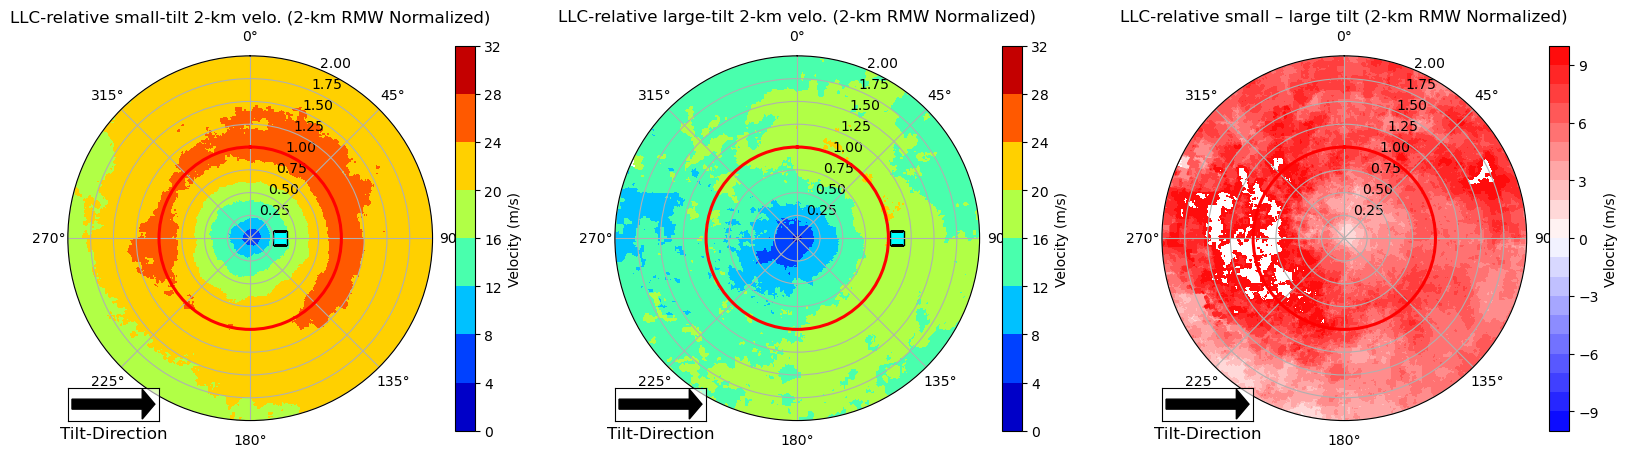

In [9]:
# Make polar RMW normalized plots

small_tilt_cylindrical_cases = all_cylindrical_tc_radar_xr.sel(num_cases = small_tilt_indices)
large_tilt_cylindrical_cases = all_cylindrical_tc_radar_xr.sel(num_cases = large_tilt_indices)


# Find MLCs on polar plots
large_tilt_mlcs_x = mlc_pd['MLC X (rotated)'][large_tilt_indices]
large_tilt_mlcs_y = mlc_pd['MLC Y (rotated)'][large_tilt_indices]

small_tilt_mlcs_x = mlc_pd['MLC X (rotated)'][small_tilt_indices]
small_tilt_mlcs_y = mlc_pd['MLC Y (rotated)'][small_tilt_indices]

small_tilt_rmws = filtered_tc_radar['tc_rmw'].sel(num_cases=small_tilt_indices,level=2)
large_tilt_rmws = filtered_tc_radar['tc_rmw'].sel(num_cases=large_tilt_indices,level=2)

norm_large_tilt_mlc_r = (np.sqrt((large_tilt_mlcs_x**2)+(large_tilt_mlcs_y**2))/large_tilt_rmws).mean()
norm_large_tilt_mlc_ang = (90 * (np.pi/180)) - (np.arctan(large_tilt_mlcs_y.mean()/large_tilt_mlcs_x.mean()))

norm_small_tilt_mlc_r = (np.sqrt((small_tilt_mlcs_x**2)+(small_tilt_mlcs_y**2))/small_tilt_rmws).mean()
norm_small_tilt_mlc_ang = (90 * (np.pi/180)) - (np.arctan(small_tilt_mlcs_y.mean()/small_tilt_mlcs_x.mean()))

fig = plt.figure(figsize=(20, 5)) 
gs = fig.add_gridspec(1,3)

ax = fig.add_subplot(gs[0, 0],adjustable='box', aspect=1,projection='polar')
ax2 = fig.add_subplot(gs[0, 1],adjustable='box', aspect=1,projection='polar')
ax3 = fig.add_subplot(gs[0, 2],adjustable='box', aspect=1,projection='polar')

ax.grid(True)
ax.set_theta_direction(-1)
ax.set_theta_zero_location('N')
if data_selection == 'recentered_reflectivity':
    s_plot = ax.contourf(small_tilt_cylindrical_cases['azimuth'], small_tilt_cylindrical_cases['radius'],
                         small_tilt_cylindrical_cases.mean('num_cases'),cmap='jet',
                     levels=np.arange(0,35.1,2.5))
else:
    s_plot = ax.contourf(small_tilt_cylindrical_cases['azimuth'], small_tilt_cylindrical_cases['radius'],
                         small_tilt_cylindrical_cases.mean('num_cases'),cmap='jet',
                     levels=np.arange(0,32.1,4))
ax_gl = ax.get_ygridlines()
ax_b = ax_gl[3]
ax_b.set_color('red')
ax_b.set_linewidth(2.2)

ax.set_rlim(0,2)
axins = inset_axes(ax, width="25%", height="9%", loc=3, borderpad=0)
axins.tick_params(labelleft=False, labelbottom=False,left = False,bottom = False)
axins.patch.set_alpha(0.6)
axins.set_title(rotate_setting, y=-0.8)
q = axins.arrow(0,0,0.05,0,color='black',head_length = 0.009)
ax.scatter(norm_small_tilt_mlc_ang,norm_small_tilt_mlc_r,s=100,linewidths = 1,edgecolors = 'k',color='cyan',marker='s',label='Mid-Level Center')

if data_selection == 'recentered_reflectivity':
    plt.colorbar(s_plot,label='Reflectivity (dBZ)')
    ax.set_title('LLC-relative small-tilt 2-km ref. (2-km RMW Normalized)')
    s_plot_2 = ax.contour(small_tilt_cylindrical_cases['azimuth'], small_tilt_cylindrical_cases['radius'],
                     small_tilt_cylindrical_cases.mean('num_cases'),cmap='jet',
                 levels=[20])

else:
    plt.colorbar(s_plot,label='Velocity (m/s)')
    ax.set_title('LLC-relative small-tilt 2-km velo. (2-km RMW Normalized)')



ax2.grid(True)
ax2.set_theta_direction(-1)
ax2.set_theta_zero_location('N')
if data_selection == 'recentered_reflectivity':
    l_plot = ax2.contourf(large_tilt_cylindrical_cases['azimuth'], large_tilt_cylindrical_cases['radius'],
                         large_tilt_cylindrical_cases.mean('num_cases'),cmap='jet',
                     levels=np.arange(0,35.1,2.5))
else:
    l_plot = ax2.contourf(large_tilt_cylindrical_cases['azimuth'], large_tilt_cylindrical_cases['radius'],
                         large_tilt_cylindrical_cases.mean('num_cases'),cmap='jet',
                     levels=np.arange(0,32.1,4))  
ax2.set_rlim(0,2)
axins2 = inset_axes(ax2, width="25%", height="9%", loc=3, borderpad=0)
axins2.tick_params(labelleft=False, labelbottom=False,left = False,bottom = False)
axins2.patch.set_alpha(0.6)
axins2.set_title(rotate_setting, y=-0.8)
q2 = axins2.arrow(0,0,0.05,0,color='black',head_length = 0.009)
ax2.scatter(norm_large_tilt_mlc_ang,norm_large_tilt_mlc_r,s=100,linewidths = 1,edgecolors = 'k',color='cyan',marker='s',label='Mid-Level Center')

ax2_gl = ax2.get_ygridlines()
ax2_b = ax2_gl[3]
ax2_b.set_color('red')
ax2_b.set_linewidth(2.2)
if data_selection == 'recentered_reflectivity':
    plt.colorbar(l_plot,label='Reflectivity (dBZ)')
    ax2.set_title('LLC-relative large-tilt 2-km ref. (2-km RMW Normalized)')
    l_plot_2 = ax2.contour(large_tilt_cylindrical_cases['azimuth'], large_tilt_cylindrical_cases['radius'],
                     large_tilt_cylindrical_cases.mean('num_cases'),cmap='jet',
                 levels=[20])

else:
    plt.colorbar(l_plot,label='Velocity (m/s)')
    ax2.set_title('LLC-relative large-tilt 2-km velo. (2-km RMW Normalized)')


ax3.grid(True)
ax3.set_theta_direction(-1)
ax3.set_theta_zero_location('N')
d_plot = ax3.contourf(large_tilt_cylindrical_cases['azimuth'], large_tilt_cylindrical_cases['radius'],
                     small_tilt_cylindrical_cases.mean('num_cases')-
                      large_tilt_cylindrical_cases.mean('num_cases'),cmap='bwr',
                     levels=np.arange(-10,10.1,1))
ax3_gl = ax3.get_ygridlines()
ax3_b = ax3_gl[3]
ax3_b.set_color('red')
ax3_b.set_linewidth(2.2)
ax3.set_rlim(0,2)
ax3.set_title('LLC-relative small – large tilt (2-km RMW Normalized)')
axins3 = inset_axes(ax3, width="25%", height="9%", loc=3, borderpad=0)
axins3.tick_params(labelleft=False, labelbottom=False,left = False,bottom = False)
axins3.patch.set_alpha(0.6)
axins3.set_title(rotate_setting, y=-0.8)
q3 = axins3.arrow(0,0,0.05,0,color='black',head_length = 0.009)

if data_selection == 'recentered_reflectivity':

    plt.colorbar(d_plot,label='Reflectivity (dBZ)')
else:
    plt.colorbar(d_plot,label='Velocity (m/s)')


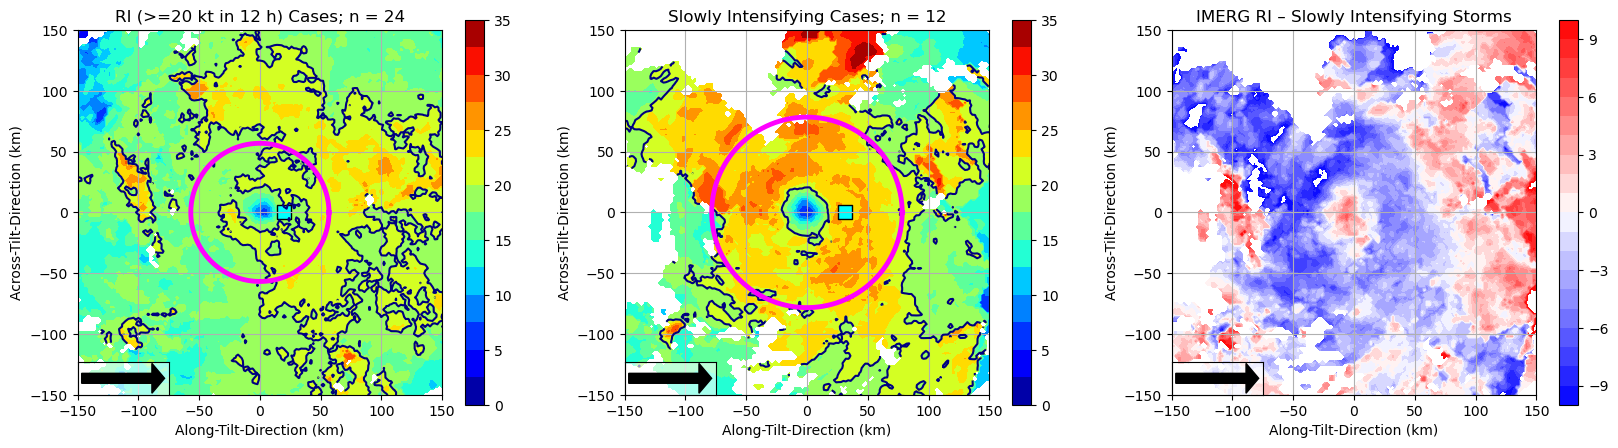

In [10]:
# Plot composites by intensity CHANGE (physical space)

# Find mean MLCS Locations


# Sort by Intensity Change

future_time = 12
future_change = filtered_tc_radar['vmax_ships'].sel(num_ships_times=future_time
                                   )- filtered_tc_radar['vmax_ships'].sel(num_ships_times=0)

storm_intensity_filter = 'Weak Only'

if storm_intensity_filter == 'Weak Only':
    future_change = future_change.sel(num_cases=weak_cases['num_cases'].values)

# Toggle Shear Filtering (only affects intensity change plotting)


RI_cases = future_change.where(future_change >= 20).dropna('num_cases')
Intensifying_cases = future_change.where((future_change > 5) & (future_change < 20)).dropna('num_cases')
SS_cases = future_change.where((future_change >= -5) & (future_change <= 5)).dropna('num_cases')
Weakening_cases = future_change.where(future_change < -5).dropna('num_cases')

RI_rmw = filtered_tc_radar['tc_rmw'].sel(num_cases=RI_cases['num_cases'],level=2)
intensifying_rmw = filtered_tc_radar['tc_rmw'].sel(num_cases=Intensifying_cases['num_cases'],level=2)
SS_rmw = filtered_tc_radar['tc_rmw'].sel(num_cases=SS_cases['num_cases'],level=2)
Weakening_rmw = filtered_tc_radar['tc_rmw'].sel(num_cases=Weakening_cases['num_cases'],level=2)

# Find MLCs
weakening_cases_mlcs_x = mlc_pd['MLC X (rotated)'][Weakening_cases['num_cases']]
weakening_cases_mlcs_y = mlc_pd['MLC Y (rotated)'][Weakening_cases['num_cases']]
intensifying_cases_mlcs_x = mlc_pd['MLC X (rotated)'][Intensifying_cases['num_cases']]
intensifying_cases_mlcs_y = mlc_pd['MLC Y (rotated)'][Intensifying_cases['num_cases']]
SS_cases_mlcs_x = mlc_pd['MLC X (rotated)'][SS_cases['num_cases']]
SS_cases_mlcs_y = mlc_pd['MLC Y (rotated)'][SS_cases['num_cases']]
RI_cases_mlcs_x = mlc_pd['MLC X (rotated)'][RI_cases['num_cases']]
RI_cases_mlcs_y = mlc_pd['MLC Y (rotated)'][RI_cases['num_cases']]

# Draw Circle

X,Y,THETA = circle([0,0],float(RI_rmw.mean()),1000)


# Make Plots

fig = plt.figure(figsize=(20, 5)) 

gs = fig.add_gridspec(1,3)
ax = fig.add_subplot(gs[0, 0],adjustable='box', aspect=1)
ax2 = fig.add_subplot(gs[0, 1],adjustable='box', aspect=1)
ax3 = fig.add_subplot(gs[0, 2],adjustable='box', aspect=1)

RI_cf = ax.contourf(rotated_images_xr['x'], rotated_images_xr['y'],
                      rotated_images_xr.sel(num_cases=RI_cases['num_cases']).mean('num_cases'),
                    levels=np.arange(0,35.1,2.5),cmap='jet')
RI_cf_2 = ax.contour(rotated_images_xr['x'], rotated_images_xr['y'],
                      rotated_images_xr.sel(num_cases=RI_cases['num_cases']).mean('num_cases'),
                    levels=[20],cmap='jet')

ax.scatter(RI_cases_mlcs_x.mean(),RI_cases_mlcs_y.mean(),s=100,linewidths = 1,
           edgecolors = 'k',color='cyan',marker='s',label='Mid-Level Center')

ax.set_title('RI (>=20 kt in 12 h)' + ' Cases; n = '+ str(len(RI_cases)))
ax.set_xlabel('Along-'+rotate_setting +' (km)')
ax.set_ylabel('Across-'+rotate_setting +' (km)')
ax.plot(X,Y,'magenta',lw=3.5,label = str(height)+'-km RMW')

plt.colorbar(RI_cf)
ax.grid()
ax.set_xlim(-150,150)
ax.set_ylim(-150,150)
axins = inset_axes(ax, width="25%", height="9%", loc=3, borderpad=0)
axins.tick_params(labelleft=False, labelbottom=False,left = False,bottom = False)
axins.patch.set_alpha(0.6)
# axins.set_title(rotate_setting, y=-1.21)
q = axins.arrow(0,0,0.05,0,color='black',head_length = 0.009)
intensity_change_choice = 'Slowly Intensifying'

if intensity_change_choice == 'Weakening':
    X2,Y2,THETA2 = circle([0,0],float(Weakening_rmw.mean()),1000)
    data_choice = rotated_images_xr.sel(num_cases=Weakening_cases['num_cases']).mean('num_cases')
    choice_len = len(Weakening_cases)
    mlc_x_choice = weakening_cases_mlcs_x
    mlc_y_choice = weakening_cases_mlcs_y
    
elif intensity_change_choice == 'Steady-State':
    X2,Y2,THETA2 = circle([0,0],float(SS_rmw.mean()),1000)
    data_choice = rotated_images_xr.sel(num_cases=SS_cases['num_cases']).mean('num_cases')
    choice_len = len(SS_cases)
    mlc_x_choice = SS_cases_mlcs_x
    mlc_y_choice = SS_cases_mlcs_y
    
elif intensity_change_choice == 'Slowly Intensifying':
    X2,Y2,THETA2 = circle([0,0],float(intensifying_rmw.mean()),1000)
    data_choice = rotated_images_xr.sel(num_cases=Weakening_cases['num_cases']).mean('num_cases')
    choice_len = len(Weakening_cases)
    mlc_x_choice = intensifying_cases_mlcs_x
    mlc_y_choice = intensifying_cases_mlcs_y
    
choice_cf = ax2.contourf(rotated_images_xr['x'], rotated_images_xr['y'],
                      data_choice,levels=np.arange(0,35.1,2.5),cmap='jet')
choice_cf_2 = ax2.contour(rotated_images_xr['x'], rotated_images_xr['y'],
                      data_choice,levels=[20],cmap='jet')
plt.colorbar(choice_cf)
ax2.scatter(mlc_x_choice.mean(),mlc_y_choice.mean(),s=100,linewidths = 1,
           edgecolors = 'k',color='cyan',marker='s',label='Mid-Level Center')
ax2.grid()
ax2.set_xlim(-150,150)
ax2.set_ylim(-150,150)
ax2.set_title(intensity_change_choice + ' Cases; n = '+ str(choice_len))
ax2.set_xlabel('Along-'+rotate_setting +' (km)')
ax2.set_ylabel('Across-'+rotate_setting +' (km)')
ax2.plot(X2,Y2,'magenta',lw=3.5,label = str(height)+'-km RMW')
axins2 = inset_axes(ax2, width="25%", height="9%", loc=3, borderpad=0)
axins2.tick_params(labelleft=False, labelbottom=False,left = False,bottom = False)
axins2.patch.set_alpha(0.6)
# axins2.set_title(rotate_setting, y=-1.21)
q2 = axins2.arrow(0,0,0.05,0,color='black',head_length = 0.009)
diff_cf = ax3.contourf(rotated_images_xr['x'], rotated_images_xr['y'],
                      rotated_images_xr.sel(num_cases=RI_cases['num_cases']).mean('num_cases')-
                         data_choice,levels=np.arange(-10,10.1,1),cmap='bwr')

plt.colorbar(diff_cf)
ax3.grid()
ax3.set_xlim(-150,150)
ax3.set_ylim(-150,150)
ax3.set_title('IMERG RI – ' +str(intensity_change_choice) +' Storms')
ax3.set_xlabel('Along-'+rotate_setting +' (km)')
ax3.set_ylabel('Across-'+rotate_setting +' (km)')
axins3 = inset_axes(ax3, width="25%", height="9%", loc=3, borderpad=0)
axins3.tick_params(labelleft=False, labelbottom=False,left = False,bottom = False)
axins3.patch.set_alpha(0.6)
# axins3.set_title(rotate_setting, y=-1.21)
q3 = axins3.arrow(0,0,0.05,0,color='black',head_length = 0.009)


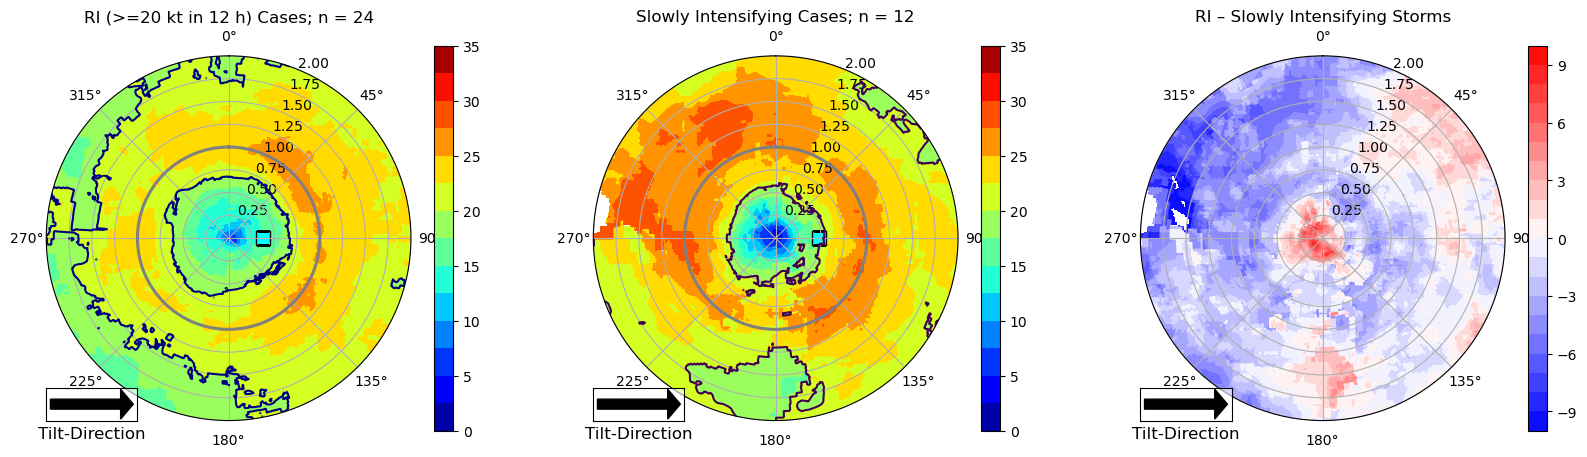

In [11]:
# Plot composites by intensity CHANGE (polar plots rmw-normalized)

# Find mean MLCS Locations


# Sort by Intensity Change

# future_time = 12
# future_change = filtered_tc_radar['vmax_ships'].sel(num_ships_times=future_time
#                                    )- filtered_tc_radar['vmax_ships'].sel(num_ships_times=0)

# storm_intensity_filter = 'Weak Only'

# if storm_intensity_filter == 'Weak Only':
#     future_change = future_change.sel(num_cases=weak_cases['num_cases'].values)

# # Toggle Shear Filtering (only affects intensity change plotting)


# RI_cases = future_change.where(future_change >= 20).dropna('num_cases')
# Intensifying_cases = future_change.where((future_change > 5) & (future_change < 20)).dropna('num_cases')
# SS_cases = future_change.where((future_change >= -5) & (future_change <= 5)).dropna('num_cases')
# Weakening_cases = future_change.where(future_change < -5).dropna('num_cases')

# RI_rmw = filtered_tc_radar['tc_rmw'].sel(num_cases=RI_cases['num_cases'],level=2)
# intensifying_rmw = filtered_tc_radar['tc_rmw'].sel(num_cases=Intensifying_cases['num_cases'],level=2)
# SS_rmw = filtered_tc_radar['tc_rmw'].sel(num_cases=SS_cases['num_cases'],level=2)
# Weakening_rmw = filtered_tc_radar['tc_rmw'].sel(num_cases=Weakening_cases['num_cases'],level=2)

# # Find MLCs
# weakening_cases_mlcs_x = mlc_pd['MLC X (rotated)'][Weakening_cases['num_cases']]
# weakening_cases_mlcs_y = mlc_pd['MLC Y (rotated)'][Weakening_cases['num_cases']]
# intensifying_cases_mlcs_x = mlc_pd['MLC X (rotated)'][Intensifying_cases['num_cases']]
# intensifying_cases_mlcs_y = mlc_pd['MLC Y (rotated)'][Intensifying_cases['num_cases']]
# SS_cases_mlcs_x = mlc_pd['MLC X (rotated)'][SS_cases['num_cases']]
# SS_cases_mlcs_y = mlc_pd['MLC Y (rotated)'][SS_cases['num_cases']]
# RI_cases_mlcs_x = mlc_pd['MLC X (rotated)'][RI_cases['num_cases']]
# RI_cases_mlcs_y = mlc_pd['MLC Y (rotated)'][RI_cases['num_cases']]

# # Draw Circle

# X,Y,THETA = circle([0,0],float(RI_rmw.mean()),1000)

norm_RI_mlc_r = (np.sqrt((RI_cases_mlcs_x**2)+(RI_cases_mlcs_y**2))/RI_rmw).mean()
norm_RI_mlc_ang = (90 * (np.pi/180)) - (np.arctan(RI_cases_mlcs_y.mean()/RI_cases_mlcs_x.mean()))

# Make Plots

fig = plt.figure(figsize=(20, 5)) 

gs = fig.add_gridspec(1,3)
ax = fig.add_subplot(gs[0, 0],adjustable='box', aspect=1,projection='polar')
ax2 = fig.add_subplot(gs[0, 1],adjustable='box', aspect=1,projection='polar')
ax3 = fig.add_subplot(gs[0, 2],adjustable='box', aspect=1,projection='polar')

RI_cf = ax.contourf(all_cylindrical_tc_radar_xr['azimuth'], all_cylindrical_tc_radar_xr['radius'],
                      all_cylindrical_tc_radar_xr.sel(num_cases=RI_cases['num_cases']).mean('num_cases'),
                    levels=np.arange(0,35.1,2.5),cmap='jet')
RI_cf_2 = ax.contour(all_cylindrical_tc_radar_xr['azimuth'], all_cylindrical_tc_radar_xr['radius'],
                      all_cylindrical_tc_radar_xr.sel(num_cases=RI_cases['num_cases']).mean('num_cases'),
                    levels=[20],cmap='jet')
ax.grid(True)
ax.set_theta_direction(-1)
ax.set_theta_zero_location('N')
ax_gl = ax.get_ygridlines()
ax_b = ax_gl[3]
ax_b.set_color('gray')
ax_b.set_linewidth(2.2)

ax.set_rlim(0,2)
axins = inset_axes(ax, width="25%", height="9%", loc=3, borderpad=0)
axins.tick_params(labelleft=False, labelbottom=False,left = False,bottom = False)
axins.patch.set_alpha(0.6)
axins.set_title(rotate_setting, y=-0.8)
q = axins.arrow(0,0,0.05,0,color='black',head_length = 0.009)
ax.scatter(norm_RI_mlc_ang.mean(),norm_RI_mlc_r.mean(),s=100,linewidths = 1,
           edgecolors = 'k',color='cyan',marker='s',label='Mid-Level Center')

ax.set_title('RI (>=20 kt in 12 h)' + ' Cases; n = '+ str(len(RI_cases)))

plt.colorbar(RI_cf)

intensity_change_choice = 'Slowly Intensifying'

if intensity_change_choice == 'Weakening':
    data_choice = all_cylindrical_tc_radar_xr.sel(num_cases=Weakening_cases['num_cases']).mean('num_cases')
    choice_len = len(Weakening_cases)
    mlc_x_choice = weakening_cases_mlcs_x
    mlc_y_choice = weakening_cases_mlcs_y
    choice_rmw = Weakening_rmw
    
elif intensity_change_choice == 'Steady-State':
    data_choice = all_cylindrical_tc_radar_xr.sel(num_cases=SS_cases['num_cases']).mean('num_cases')
    choice_len = len(SS_cases)
    mlc_x_choice = SS_cases_mlcs_x
    mlc_y_choice = SS_cases_mlcs_y
    choice_rmw = SS_rmw

elif intensity_change_choice == 'Slowly Intensifying':
    data_choice = all_cylindrical_tc_radar_xr.sel(num_cases=Weakening_cases['num_cases']).mean('num_cases')
    choice_len = len(Weakening_cases)
    mlc_x_choice = intensifying_cases_mlcs_x
    mlc_y_choice = intensifying_cases_mlcs_y
    choice_rmw = intensifying_rmw
    
choice_cf = ax2.contourf(all_cylindrical_tc_radar_xr['azimuth'], all_cylindrical_tc_radar_xr['radius'],
                      data_choice,levels=np.arange(0,35.1,2.5),cmap='jet')
choice_cf_2 = ax2.contour(all_cylindrical_tc_radar_xr['azimuth'], all_cylindrical_tc_radar_xr['radius'],
                      data_choice,levels=[20])
plt.colorbar(choice_cf)

# Find choice case r and angle location for MLC in polar plot
norm_choice_mlc_r = (np.sqrt((mlc_x_choice**2)+(mlc_y_choice**2))/choice_rmw).mean()
norm_choice_case_mlc_ang = (90 * (np.pi/180)) - (np.arctan(mlc_y_choice.mean()/mlc_x_choice.mean()))


ax2.scatter(norm_choice_case_mlc_ang,norm_choice_mlc_r,
            s=100,linewidths = 1,edgecolors = 'k',color='cyan',
            marker='s',label='Mid-Level Center')

ax2.grid(True)
ax2.set_theta_direction(-1)
ax2.set_theta_zero_location('N')
ax2_gl = ax2.get_ygridlines()
ax2_b = ax2_gl[3]
ax2_b.set_color('gray')
ax2_b.set_linewidth(2.2)
ax2.set_rlim(0,2)
ax2.set_title(intensity_change_choice + ' Cases; n = '+ str(choice_len))
axins2 = inset_axes(ax2, width="25%", height="9%", loc=3, borderpad=0)
axins2.tick_params(labelleft=False, labelbottom=False,left = False,bottom = False)
axins2.patch.set_alpha(0.6)
axins2.set_title(rotate_setting, y=-0.8)
q2 = axins2.arrow(0,0,0.05,0,color='black',head_length = 0.009)

diff_cf = ax3.contourf(all_cylindrical_tc_radar_xr['azimuth'], all_cylindrical_tc_radar_xr['radius'],
                      all_cylindrical_tc_radar_xr.sel(num_cases=RI_cases['num_cases']).mean('num_cases')-
                         data_choice,levels=np.arange(-10,10.1,1),cmap='bwr')

plt.colorbar(diff_cf)
ax3.grid()
ax3.set_title('RI – ' +str(intensity_change_choice) +' Storms')
ax3.grid(True)
ax3.set_theta_direction(-1)
ax3.set_theta_zero_location('N')
ax3_gl = ax2.get_ygridlines()
ax3_b = ax2_gl[3]
ax_b.set_color('gray')
ax3_b.set_linewidth(2.2)
ax3.set_rlim(0,2)
axins3 = inset_axes(ax3, width="25%", height="9%", loc=3, borderpad=0)
axins3.tick_params(labelleft=False, labelbottom=False,left = False,bottom = False)
axins3.patch.set_alpha(0.6)
axins3.set_title(rotate_setting, y=-0.8)
q3 = axins3.arrow(0,0,0.05,0,color='black',head_length = 0.009)

In [12]:
tilt_bin_edges = [4,8,12,16,20,24,28,36]

bin_list = [] # Put each storm's tilts into bins, including the index, which will be used later

strong_info_xr = filtered_tc_radar.sel(num_cases=strong_cases['num_cases'].values)

for bin_i in range(len(tilt_bin_edges)):
    if bin_i == 0:
        bin_edge_now_tilt = tilt_mag.sel(num_cases=strong_info_xr['num_cases'].values
                                 ).where(tilt_mag.sel(num_cases=strong_info_xr['num_cases'].values) <
                                         tilt_bin_edges[bin_i]).dropna('num_cases')['num_cases']
    else:
        bin_edge_now_tilt = tilt_mag.sel(num_cases=strong_info_xr['num_cases'].values
                                 ).where((tilt_mag.sel(num_cases=strong_info_xr['num_cases'].values) <
                                         tilt_bin_edges[bin_i]) & (tilt_mag.sel(num_cases=strong_info_xr['num_cases'].values) >=
                                         tilt_bin_edges[bin_i-1])).dropna('num_cases')['num_cases']
    bin_list.append(bin_edge_now_tilt)

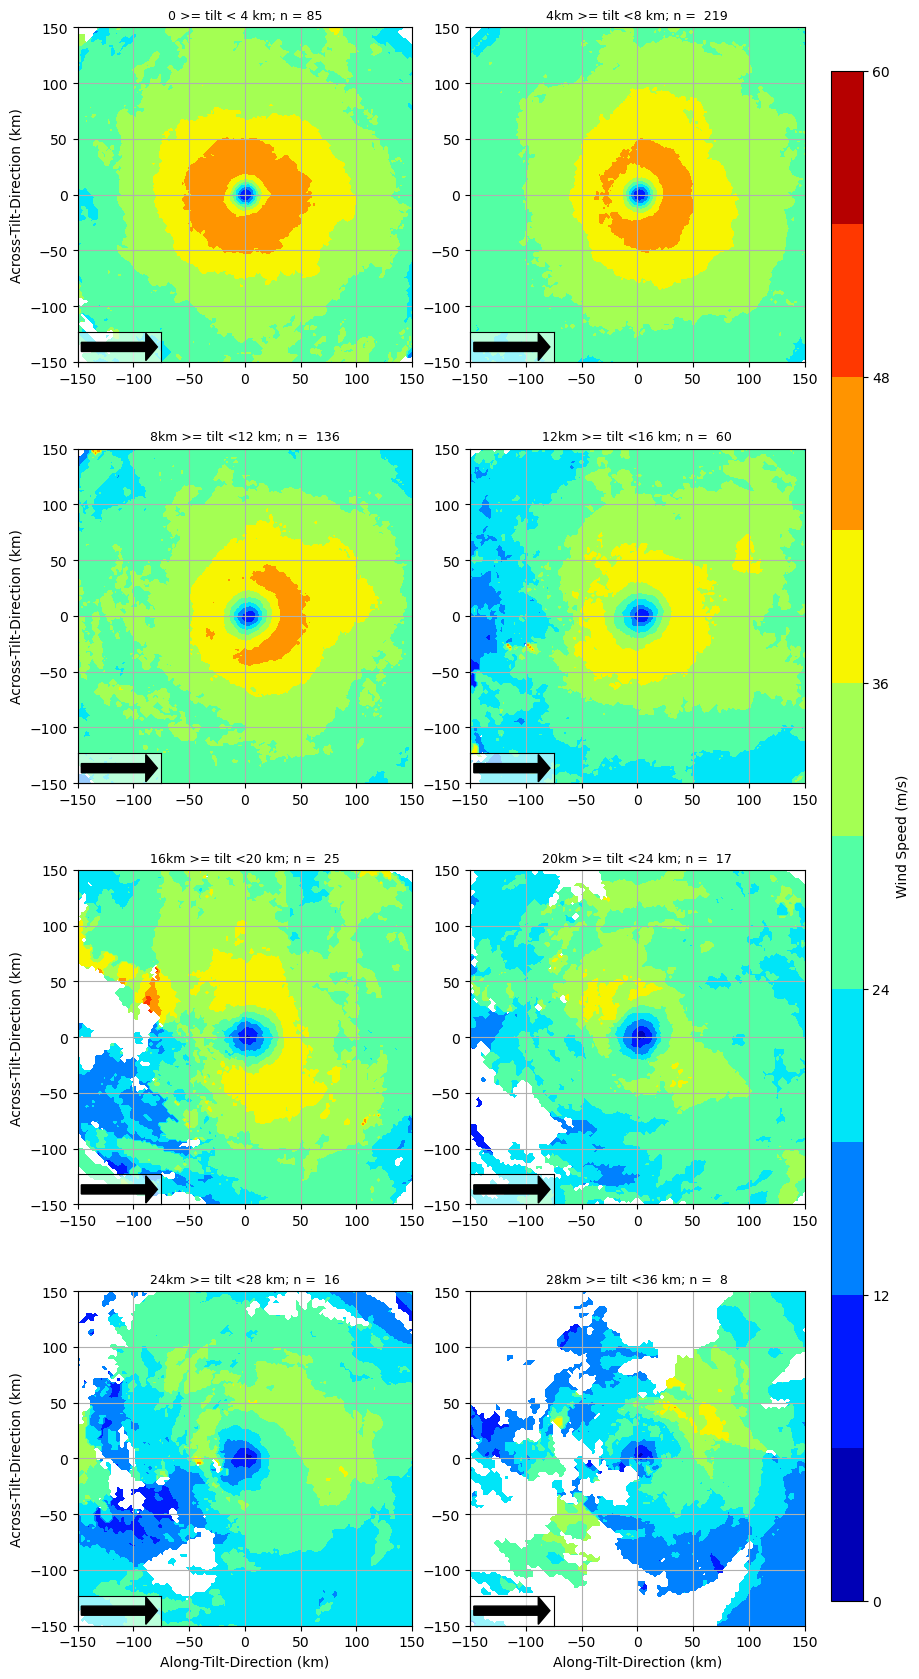

In [13]:
# Make subplots of strong TC precip field with varying tilt bins
fig, ax = plt.subplots(nrows=4, ncols=2,figsize=(8, 17),subplot_kw = dict(adjustable='box', aspect=1))
ax_iteration = 0
plt.tight_layout()

for ax_i in ax.flatten():
    ax_i.set_xticks(np.arange(-150,150.1,50))
    ax_i.grid()
#     ax_i.set_xlabel('Along-Tilt Direction (km)')
#     ax_i.set_ylabel('Across-Tilt Direction (km)')
    if data_selection == 'recentered_reflectivity':
        cf_iter = ax_i.contourf(rotated_images_xr['x'],
                    rotated_images_xr['y'],
                                       rotated_images_xr.sel(num_cases=bin_list[ax_iteration].values).mean(
                                           'num_cases'),cmap='jet',levels=np.arange(0,35.1,2.5))
        cf_iter_2 = ax_i.contour(rotated_images_xr['x'],
                    rotated_images_xr['y'],
                                       rotated_images_xr.sel(num_cases=bin_list[ax_iteration].values).mean(
                                           'num_cases'),cmap='jet',levels=[25])
    else:
        cf_iter = ax_i.contourf(rotated_images_xr['x'],
                    rotated_images_xr['y'],
                                       rotated_images_xr.sel(num_cases=bin_list[ax_iteration].values).mean(
                                           'num_cases'),cmap='jet',levels=np.arange(0,60.1,6))

    n_cases = len(rotated_images_xr.sel(num_cases=bin_list[ax_iteration].values))

    if ax_iteration == 0:
        ax_i.set_title('0 >= tilt < '+str(tilt_bin_edges[ax_iteration])+' km; n = ' + str(n_cases),fontsize=9)
    else:
        ax_i.set_title(str(tilt_bin_edges[ax_iteration-1]) + 'km >= tilt <' +
                       str(tilt_bin_edges[ax_iteration]) + ' km; n =  ' + str(n_cases),
                       fontsize=9)
        
    axins_i = inset_axes(ax_i, width="25%", height="9%", loc=3, borderpad=0)
    axins_i.tick_params(labelleft=False, labelbottom=False,left = False,bottom = False)
    axins_i.patch.set_alpha(0.6)
#     axins_i.set_title(rotate_setting, y=-1.45)
    q_i = axins_i.arrow(0,0,0.05,0,color='black',head_length = 0.009)
    ax_i.set_xlim(-150,150)
    ax_i.set_ylim(-150,150)
    if (ax_iteration == 6) or (ax_iteration == 7):
        ax_i.set_xlabel('Along-'+rotate_setting +' (km)')
    if (ax_iteration == 0) or (ax_iteration == 2) or (ax_iteration == 4) or (ax_iteration == 6):
        ax_i.set_ylabel('Across-'+rotate_setting +' (km)')

    ax_iteration = ax_iteration + 1

    
cax = plt.axes([1, 0.05, 0.04, 0.9])

if data_selection == 'recentered_reflectivity':
    plt.colorbar(cf_iter,cax=cax,label='Reflectivity (dBZ)')    
else:
    plt.colorbar(cf_iter,cax=cax,label='Wind Speed (m/s)')




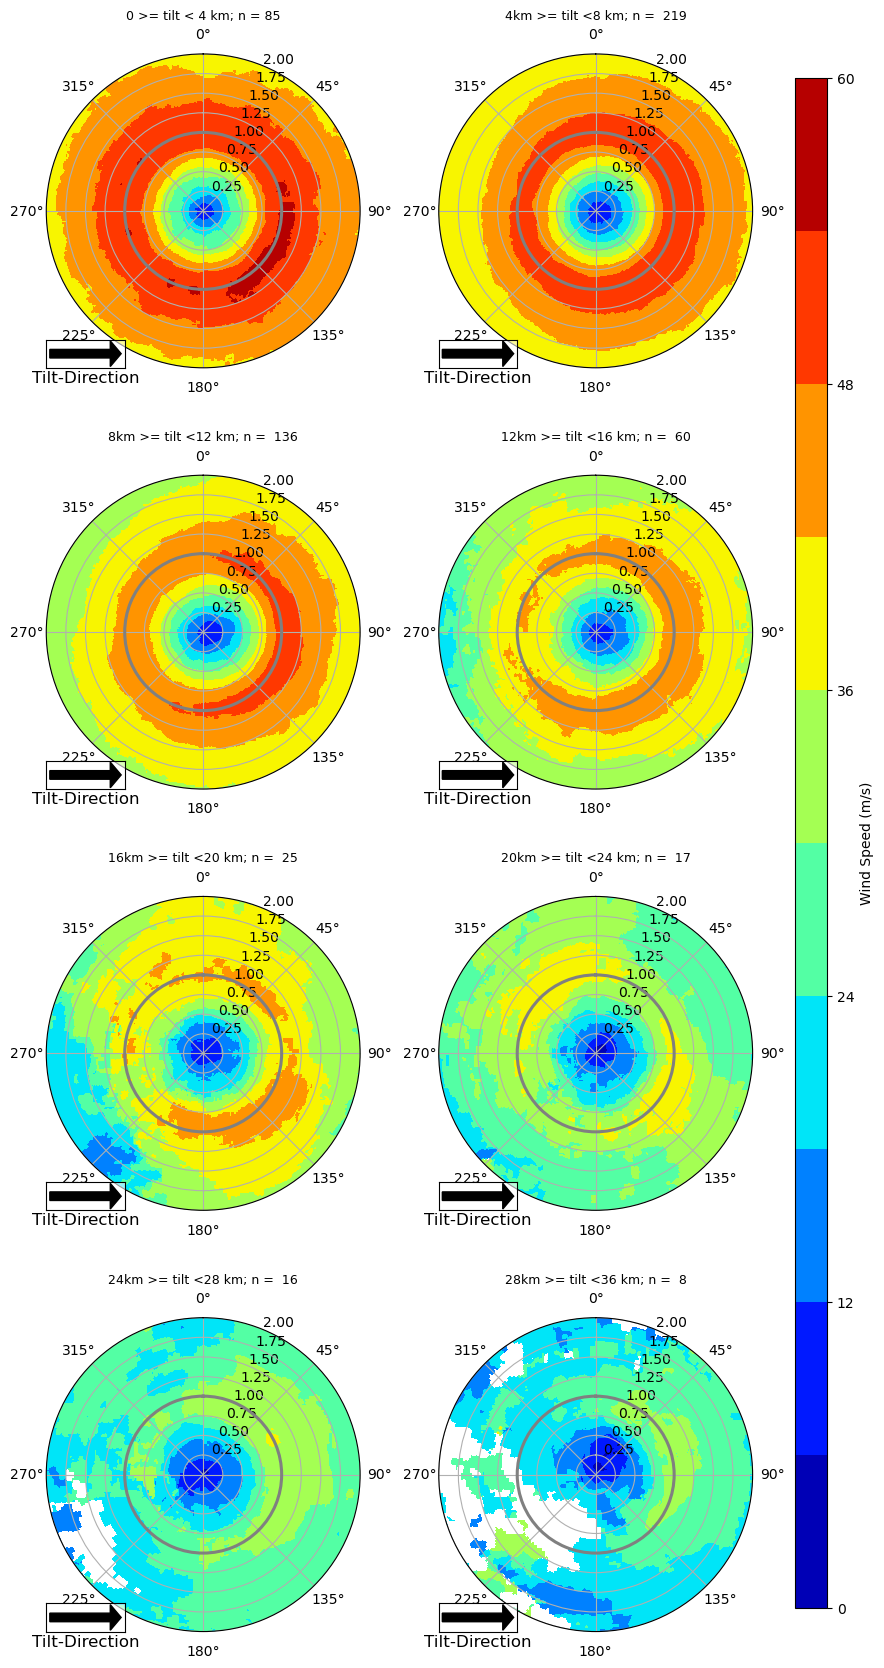

In [14]:
# Make subplots of strong TC precip field with varying tilt bins
fig, ax = plt.subplots(nrows=4, ncols=2,figsize=(8, 17),subplot_kw = dict(projection='polar'))
ax_iteration = 0
plt.tight_layout()

for ax_i in ax.flatten():
#     ax_i.set_xlabel('Along-Tilt Direction (km)')
#     ax_i.set_ylabel('Across-Tilt Direction (km)')
    if data_selection == 'recentered_reflectivity':
        cf_iter = ax_i.contourf(all_cylindrical_tc_radar_xr['azimuth'],
                    all_cylindrical_tc_radar_xr['radius'],
                                       all_cylindrical_tc_radar_xr.sel(num_cases=bin_list[ax_iteration].values).mean(
                                           'num_cases'),cmap='jet',levels=np.arange(0,35.1,2.5))
        cf_iter_2 = ax_i.contour(all_cylindrical_tc_radar_xr['azimuth'],
                    all_cylindrical_tc_radar_xr['radius'],
                                       all_cylindrical_tc_radar_xr.sel(num_cases=bin_list[ax_iteration].values).mean(
                                           'num_cases'),cmap='jet',levels=[30])
    else:
        cf_iter = ax_i.contourf(all_cylindrical_tc_radar_xr['azimuth'],
                    all_cylindrical_tc_radar_xr['radius'],
                                       all_cylindrical_tc_radar_xr.sel(num_cases=bin_list[ax_iteration].values).mean(
                                           'num_cases'),cmap='jet',levels=np.arange(0,60.1,6))
    
    n_cases = len(all_cylindrical_tc_radar_xr.sel(num_cases=bin_list[ax_iteration].values))

    if ax_iteration == 0:
        ax_i.set_title('0 >= tilt < '+str(tilt_bin_edges[ax_iteration])+' km; n = ' + str(n_cases),fontsize=9)
    else:
        ax_i.set_title(str(tilt_bin_edges[ax_iteration-1]) + 'km >= tilt <' +
                       str(tilt_bin_edges[ax_iteration]) + ' km; n =  ' + str(n_cases),
                       fontsize=9)
    ax_i.set_rlim(0,2)
    ax_i_gl = ax_i.get_ygridlines()
    ax_i_b = ax_i_gl[3]
    ax_i_b.set_color('gray')
    ax_i_b.set_linewidth(2.2)
    ax_i.set_theta_direction(-1)
    ax_i.set_theta_zero_location('N')
    axins_i = inset_axes(ax_i, width="25%", height="9%", loc=3, borderpad=0)
    axins_i.tick_params(labelleft=False, labelbottom=False,left = False,bottom = False)
    axins_i.patch.set_alpha(0.6)
    axins_i.set_title(rotate_setting, y=-0.8)
    q_i = axins_i.arrow(0,0,0.05,0,color='black',head_length = 0.009)
    ax_iteration = ax_iteration + 1
    
cax = plt.axes([1, 0.05, 0.04, 0.9])
if data_selection == 'recentered_reflectivity':
    plt.colorbar(cf_iter,cax=cax,label='Reflectivity (dBZ)')
else:
    plt.colorbar(cf_iter,cax=cax,label='Wind Speed (m/s)')


Text(0.5, 1.0, 'Vortex Tilt Magnitude (${r_s}$ = -0.65)')

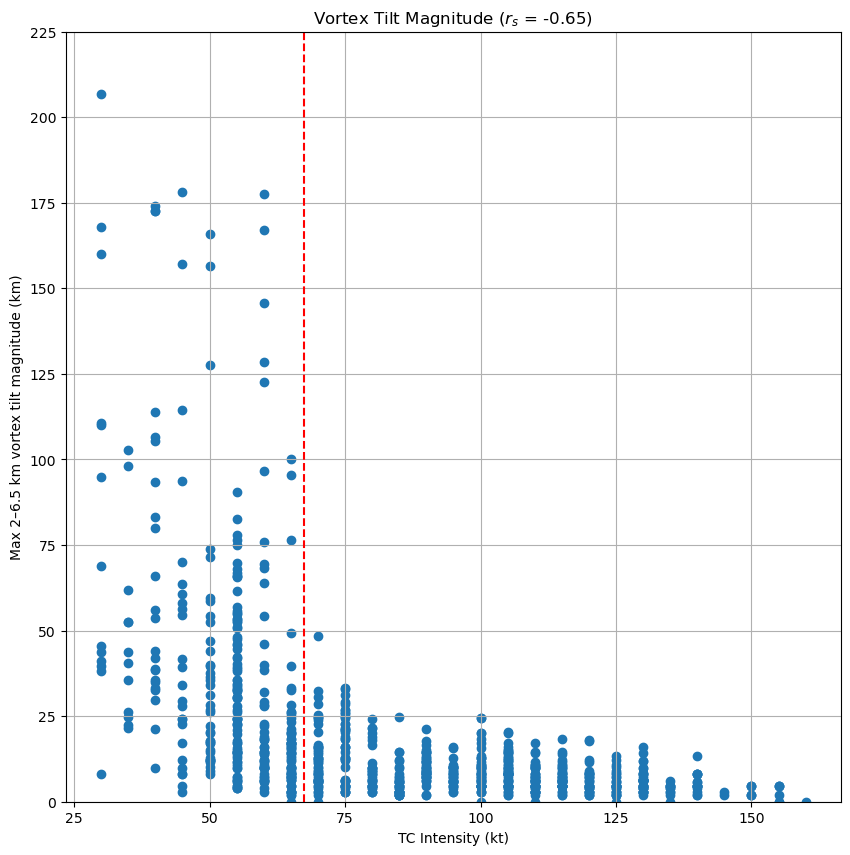

In [15]:
res = stats.spearmanr(filtered_tc_radar['vmax_ships'].sel(num_ships_times=0,num_cases=result),
                     tilt_mag.sel(num_cases=result))

plt.figure(figsize=(10,10))
plt.scatter(filtered_tc_radar['vmax_ships'].sel(num_ships_times=0,num_cases=result),tilt_mag.sel(num_cases=result))
plt.vlines(67.5,ymin=0,ymax=250,color='red',linestyle='dashed')
plt.grid()
plt.xticks(np.arange(25,150.1,25))
plt.yticks(np.arange(0,225.1,25))
plt.ylim(0,225)
plt.ylabel('Max 2–6.5 km vortex tilt magnitude (km)')
plt.xlabel('TC Intensity (kt)')
plt.title('Vortex Tilt Magnitude (${r_s}$ = ' + str(round(res.statistic,2)) +')')


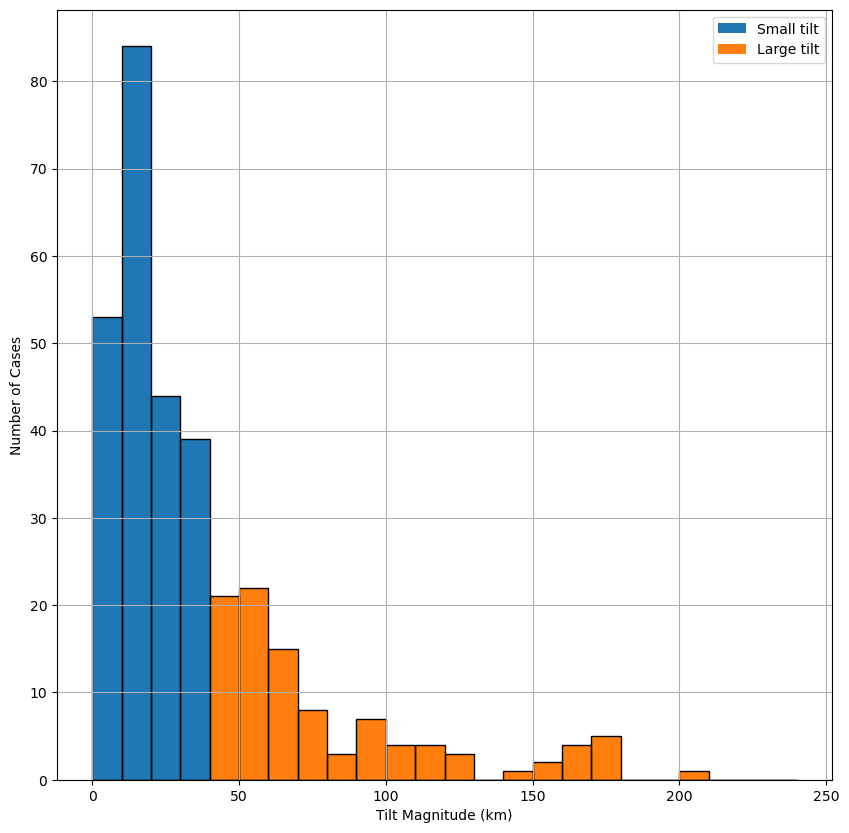

In [16]:
plt.figure(figsize=(10,10))
plt.grid()
plt.hist(tilt_mag.sel(num_cases = small_tilt_indices),bins=np.arange(0,250,10),label='Small tilt')
plt.hist(tilt_mag.sel(num_cases = large_tilt_indices),bins=np.arange(0,250,10),label='Large tilt')
plt.hist(tilt_mag.sel(num_cases = small_tilt_indices),bins=np.arange(0,250,10),rwidth=1,fill=False)
plt.hist(tilt_mag.sel(num_cases = large_tilt_indices),bins=np.arange(0,250,10),rwidth=1,fill=False)
plt.ylabel('Number of Cases')
plt.xlabel('Tilt Magnitude (km)')
plt.yticks(np.arange(0,80.1,10))
plt.legend()
